In [1]:
import pandas as pd
# from retentioneering import datasets
from typing import Literal, Union, List, Optional, Iterable, get_args, Dict, Tuple
import numpy as np 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns

from abc import ABC, abstractmethod
import warnings

import datetime


In [2]:
import sys

sys.path.append('d:\\diplom\\product\\insight_pulse')

for path in sys.path:
    print(path)

D:\pythonProg\Python\Python312\python312.zip
D:\pythonProg\Python\Python312\DLLs
D:\pythonProg\Python\Python312\Lib
D:\pythonProg\Python\Python312
d:\diplom\.venv

d:\diplom\.venv\Lib\site-packages
d:\diplom\.venv\Lib\site-packages\win32
d:\diplom\.venv\Lib\site-packages\win32\lib
d:\diplom\.venv\Lib\site-packages\Pythonwin
d:\diplom\product\insight_pulse


In [ ]:
from eventframing.eventframe import EventFrame
from eventframing.cols_schema import EventFrameColsSchema
from eventframing.event_type import EventType


In [4]:
from data_preprocessing.preprocessors_lib.add_start_end_events import AddStartEndEventsPreprocessor
from data_preprocessing.preprocessors_lib.split_sessions import SplitSessionsPreprocessor

from utils.time_units import TimeUnits
from utils.time_unit_period import TimeUnitPeriod

## Data generation

In [5]:
def generate_user_events_data(num_users=1000, num_events=10, num_cities=10, num_os=2, num_rows=5000, seed=42):
    """
    Функция для генерации данных о событиях пользователей.
    """
    # Устанавливаем seed для генератора случайных чисел
    np.random.seed(seed)

    # Создаем список пользователей
    users = ['user' + str(i) for i in range(1, num_users+1)]

    # Создаем список событий
    events = ['event' + str(i) for i in range(1, num_events+1)]

    # Создаем список дат
    dates = [datetime.datetime.now() - datetime.timedelta(days=x) for x in range(180)]

    # Создаем список городов
    cities = ['city' + str(i) for i in range(1, num_cities+1)]

    # Создаем список операционных систем
    os = ['iOS', 'Android']

    statuses = ['status' + str(i) for i in range(1, num_os+1)]

    # Создаем DataFrame
    df = pd.DataFrame({
        'user_id': np.random.choice(users, num_rows),
        'event': np.random.choice(events, num_rows),
        'event_datetime': np.random.choice(dates, num_rows),
        'city': np.random.choice(cities, num_rows),
        'operation_system': np.random.choice(os, num_rows),
        'status': np.random.choice(statuses, num_rows)
    })

    return df

In [15]:
data = generate_user_events_data(num_rows=50000, num_users=5000)
cols_schema = {'user_id': 'user_id', 'event_timestamp': 'event_datetime', 'event_name': 'event'}
ef = EventFrame(data, cols_schema)
ef.to_dataframe().head()

EventFrameColsSchema(event_id=None, event_type=None, event_index=None, event_name=event, event_timestamp=event_datetime, user_id=user_id, session_id=None, cohort_group=None, custom_cols=[])


,user_id,event,event_datetime,city,operation_system,status,event_id,event_type,event_type_index
31830,user1,event10,2024-11-25 11:42:11.591269,city8,iOS,status1,31830,raw,2
31616,user1,event2,2024-12-14 11:42:11.591269,city2,Android,status2,31616,raw,2
18436,user1,event8,2024-12-24 11:42:11.591269,city2,iOS,status2,18436,raw,2
32891,user1,event2,2024-12-26 11:42:11.591269,city3,Android,status2,32891,raw,2
15072,user1,event3,2025-01-02 11:42:11.591269,city4,Android,status2,15072,raw,2


## Stats Class 

In [96]:
class DescStatsAnalyzer:

    _default_agg_funcs = ['mean', 'median', 'std', 'min', 'max']

    # def __init__(self, ef: EventFrame, add_start_end_events=False, split_sessions=False, split_sessions_params: Dict = None) -> None:
    #     pass

        # if add_start_end_events:
        #     ase = AddStartEndEventsPreprocessor()
        #     ef = ase.apply(ef)
        # if split_sessions:
        #     ssp = SplitSessionsPreprocessor(**split_sessions_params)
        #     ef = ssp.apply(ef)

        # self.data = ef.to_dataframe().copy()
        # self.cols_schema = ef.cols_schema

    @staticmethod
    def describe(ef: EventFrame, add_path_stats: bool = True, add_session_stats: bool = True) -> pd.DataFrame:
        data = ef.to_dataframe().copy()
        cols_schema = ef.cols_schema

        user_col = cols_schema.user_id
        event_col = cols_schema._event_name
        session_col = cols_schema.session_id
        dt_col = cols_schema.event_timestamp
        event_type_col = cols_schema.event_type

        raw_data = data[data[event_type_col] == EventType.RAW.value.name].copy()

        overall_stats = []
        overall_stats.append(['unique_users', raw_data[user_col].nunique()])
        overall_stats.append(['unique_events', raw_data[event_col].nunique()])
        if session_col:
            overall_stats.append(['unique_sessions', raw_data[session_col].nunique()])
        overall_stats.append(['frame_start', raw_data[dt_col].min()])
        overall_stats.append(['frame_end', raw_data[dt_col].max()])
        overall_stats.append(['frame_duration', raw_data[dt_col].max() - raw_data[dt_col].min()])
        # Добавляем 'overall' в начало каждого подсписка
        for overall_stats_row in overall_stats:
            overall_stats_row.insert(0, 'overall')

        path_stats = []
        if add_path_stats:
            path_stats = raw_data.groupby(user_col).agg(**{
                'path_duration': (dt_col, lambda x: x.max() - x.min()),
                'path_steps_length': (event_col, 'count'),
            })

            path_stats = DescStatsAnalyzer._compute_desc_stats(path_stats)
        
        session_stats = []
        if add_session_stats:
            if not session_col:
                raise ValueError('session_id column not defined. It is necessary to split Eventframe by sessions previously')
            
            session_stats = raw_data.groupby(session_col).agg(**{
                'session_duration': (dt_col, lambda x: x.max() - x.min()),
                'session_steps_length': (event_col, 'count'),
            })

            session_stats = DescStatsAnalyzer._compute_desc_stats(session_stats)
        
        overall_stats.extend(path_stats)
        overall_stats.extend(session_stats)
        return pd.DataFrame(overall_stats, columns=['category', 'metric', 'value']).set_index(['category', 'metric'])
    
    @staticmethod
    def describe_events(ef: EventFrame, events: Optional[List[str]] = None, add_session_stats: bool = True) -> pd.DataFrame:
        data = ef.to_dataframe().copy()
        cols_schema = ef.cols_schema

        user_col = cols_schema.user_id
        event_col = cols_schema._event_name
        session_col = cols_schema.session_id
        dt_col = cols_schema.event_timestamp
        event_type_col = cols_schema.event_type

        if add_session_stats and not session_col:
            raise ValueError('session_id column not defined. It is necessary to split Eventframe by sessions previously')

        raw_data = data[data[event_type_col] == EventType.RAW.value.name].copy()
        # Для каждого пользователя вычисляем его первое событие
        users_first_events = raw_data.groupby(user_col).agg(
            first_path_event_dt=(dt_col, 'min'),
        ).reset_index()
        # Для каждого пользователя добавляем признак порядкового номера действия на пути пользователя
        raw_data['path_step_number'] = raw_data.groupby(user_col).cumcount() + 1

        if events:
            # Фильтруем данные по событиям
            raw_data = raw_data[raw_data[event_col].isin(events)].copy()

        events_users_stats = raw_data.groupby([user_col, event_col]).agg(
            first_occarance_dt=(dt_col, 'min'),
            steps_to_first_occurance=('path_step_number', 'min'),
        ).reset_index()
        events_users_stats = events_users_stats.merge(
            users_first_events,
            on=user_col,
            how='inner'
        )
        events_users_stats['time_to_first_occurance'] = events_users_stats['first_occarance_dt'] - events_users_stats['first_path_event_dt']
        events_users_stats = events_users_stats.drop(columns=['first_occarance_dt'])

        # Для time_to_first_occurance
        time_stats = events_users_stats.groupby(event_col)['time_to_first_occurance'].agg(DescStatsAnalyzer._default_agg_funcs).reset_index()
        time_stats.set_index(event_col, inplace=True)
        time_stats.columns = pd.MultiIndex.from_product([['time_to_first_occurance'], DescStatsAnalyzer._default_agg_funcs])
 

        # Для steps_to_first_occurance
        steps_stats = events_users_stats.groupby(event_col)['steps_to_first_occurance'].agg(DescStatsAnalyzer._default_agg_funcs).reset_index()
        steps_stats.set_index(event_col, inplace=True)
        steps_stats.columns = pd.MultiIndex.from_product([['steps_to_first_occurance'], DescStatsAnalyzer._default_agg_funcs])

        # Группируем по событию и считаем необходимые метрики
        overall_stats_agg = {
            'event_count': (event_col, 'count'),
            'unique_users': (user_col, 'nunique'),
        }
        if add_session_stats and session_col:
            overall_stats_agg['unique_sessions'] = (session_col, 'nunique')
        
        overall_event_stats = raw_data.groupby(event_col).agg(**overall_stats_agg).reset_index()

        # Вычисляем проценты
        total_events = raw_data.shape[0]
        total_users = raw_data[user_col].nunique()
        overall_event_stats['event_percentage'] = (overall_event_stats['event_count'] / total_events * 100).fillna(0)
        overall_event_stats['user_percentage'] = (overall_event_stats['unique_users'] / total_users * 100).fillna(0)

        if add_session_stats and session_col:
            total_sessions = raw_data[session_col].nunique()
            overall_event_stats['session_percentage'] = (overall_event_stats['unique_sessions'] / total_sessions * 100).fillna(0)
            
        overall_event_stats.set_index(event_col, inplace=True)
        overall_event_stats.columns = pd.MultiIndex.from_product([['overall'], overall_event_stats.columns])

        event_stats = overall_event_stats\
            .merge(time_stats, right_index=True, left_index=True)\
            .merge(steps_stats, right_index=True, left_index=True)

        return event_stats.reset_index()

    @staticmethod
    def plot_lifetime_hist(ef: EventFrame, 
                           max_return_time: Optional[Union[int, TimeUnits, Tuple[int, str]]], 
                           plot_period: Union[str, TimeUnitPeriod] = 'D',
                           lower_cutoff_quantile: Optional[float] = None,
                           upper_cutoff_quantile: Optional[float] = None,
                           **hist_kwargs) -> None:
        # Обработка max_return_time
        if isinstance(max_return_time, int):
            max_return_time = pd.Timedelta(minutes=max_return_time)
        elif isinstance(max_return_time, tuple):
            max_return_time = TimeUnits(max_return_time).get_time_delta()
        elif isinstance(max_return_time, TimeUnits):
            max_return_time = max_return_time.get_time_delta()
        else:
            raise ValueError('max_return_time should be an int or TimeUnits')
        
        if isinstance(plot_period, str):
            plot_period = TimeUnitPeriod(plot_period)

        data = ef.to_dataframe().copy()
        cols_schema = ef.cols_schema

        user_col = cols_schema.user_id
        dt_col = cols_schema.event_timestamp

        # Для каждого пользователя вычисляем время первого и последнего действия
        user_life_data = data.groupby(user_col).agg(
            first_action_dt=(dt_col, 'min'),
            last_action_dt=(dt_col, 'max')
        ).reset_index()

        # Исключаем пользователей, чье последнее действие позже max_return_time
        max_dt_in_data = data[dt_col].max()
        user_life_data = user_life_data[user_life_data['last_action_dt'] <= (max_dt_in_data - max_return_time)]

        # Вычисляем продолжительность жизни пользователей
        user_life_data['lifetime'] = user_life_data['last_action_dt'] - user_life_data['first_action_dt']


        lifetimes = DescStatsAnalyzer._prepare_dist_timedelta_data(
            data=user_life_data, 
            dist_col='distance',
            new_col_name= f'lifetime ({plot_period.alias})', 
            dist_period=plot_period,
            lower_cutoff_quantile=lower_cutoff_quantile,
            upper_cutoff_quantile=upper_cutoff_quantile
        )
        DescStatsAnalyzer._plot_seaborn_hist(
            lifetimes, 
            title='Distribution of Event Distance', 
            xaxis_label=f'Lifetime ({plot_period.alias})', 
            yaxis_label='Users', 
            **hist_kwargs
        )
        # user_life_data = plot_period.add_period_col_from_timedelta(user_life_data, 'lifetime', 'lifetime_duration')
        # # return user_life_data

        # # Визуализируем распределение времени жизни пользователей
        # fig, axes = plt.subplots(figsize=(12, 6))
        # sns.histplot(user_life_data['lifetime_duration'], kde=True, **hist_kwargs)
        
        # axes.set_title('Distribution of User Lifetime')
        # axes.set_xlabel('Lifetime')
        # axes.set_ylabel('Users')
        # plt.show()

    def plot_event_distance_hist(ef: EventFrame, 
                                 event_from: Union[str, List[str]], 
                                 event_to: Union[str, List[str]],
                                 plot_period: Union[str, TimeUnitPeriod] = 'D',
                                 lower_cutoff_quantile: Optional[float] = None,
                                 upper_cutoff_quantile: Optional[float] = None,
                                 **hist_kwargs) -> None:
        data = ef.to_dataframe().copy()
        cols_schema = ef.cols_schema

        if isinstance(plot_period, str):
            plot_period = TimeUnitPeriod(plot_period)

        user_col = cols_schema.user_id
        event_col = cols_schema.event_name
        dt_col = cols_schema.event_timestamp
        
        # Проверяем, что все упомянутые события присутствуют в наборе данных
        all_events = data[event_col].unique()  
        events_to_check = [event_from] if isinstance(event_from, str) else event_from.copy()
        events_to_check += [event_to] if isinstance(event_to, str) else event_to.copy()
        for event in events_to_check:
            if event not in all_events:
                raise ValueError(f"Event '{event}' not found in the EventFrame.")

        # Переименование событий, если они переданы в виде списков
        if isinstance(event_from, list):
            event_replace = dict(zip(event_from, ['event_from'] * len(event_from)))
            print(event_replace)
            data.event = data.event.replace(event_replace, regex=False)
            event_from = 'event_from'

        if isinstance(event_to, list):
            event_replace = dict(zip(event_to, ['event_to'] * len(event_to)))
            print(event_replace)
            data.event = data.event.replace(event_replace, regex=False)
            event_to = 'event_to'
        # return data

        data = data[data[event_col].isin([event_from, event_to])]
        
        # Сортируем набор данных по user_id и временной метке
        data = data.sort_values(by=[user_col, dt_col])  
        # Рассчитываем разницу во времени до следующего события
        data['distance'] = data.groupby(user_col)[dt_col].shift(-1) - data[dt_col]
        # Оставляем только строки, где расчитано время от event_from до event_to
        distance_data = data[(data[event_col] == event_from) & (data[event_col].shift(-1) == event_to)]
            
        distances = DescStatsAnalyzer._prepare_dist_timedelta_data(
            data=distance_data, 
            dist_col='distance',
            new_col_name= f'distance ({plot_period.alias})', 
            dist_period=plot_period,
            lower_cutoff_quantile=lower_cutoff_quantile,
            upper_cutoff_quantile=upper_cutoff_quantile
        )
        DescStatsAnalyzer._plot_seaborn_hist(
            distances, 
            title='Distribution of Event Distance', 
            xaxis_label=f'Distance ({plot_period.alias})', 
            yaxis_label='Stat', 
            **hist_kwargs
        )

    def _prepare_dist_timedelta_data(
                           data: pd.DataFrame, 
                           dist_col: str, 
                           new_col_name: str,
                           dist_period: Union[str, TimeUnitPeriod],
                           lower_cutoff_quantile: Optional[float] = None,
                           upper_cutoff_quantile: Optional[float] = None,) -> pd.Series:
        if isinstance(dist_period, str):
            dist_period = TimeUnitPeriod(dist_period)
        if lower_cutoff_quantile is None:
            lower_cutoff_quantile = 0
        if upper_cutoff_quantile is None:
            upper_cutoff_quantile = 1

        data = dist_period.add_period_col_from_timedelta(data, dist_col, new_col_name)
        data = data[
            (data[new_col_name] >= data[new_col_name].quantile(lower_cutoff_quantile)) & 
            (data[new_col_name] <= data[new_col_name].quantile(upper_cutoff_quantile))
        ]
        return data[new_col_name]
    
    def _plot_seaborn_hist(data: pd.Series, title: str, xaxis_label: str, yaxis_label: str, **hist_kwargs) -> None:
        fig, axes = plt.subplots(figsize=(12, 6))
        sns.histplot(data, kde=True, **hist_kwargs)
        
        axes.set_title(title)
        axes.set_xlabel(xaxis_label)
        axes.set_ylabel(yaxis_label)
        plt.tight_layout()
        plt.show()

    def _compute_desc_stats(data: pd.DataFrame, 
                            agg_cols: Optional[List[str]] = None, 
                            agg_funcs: Optional[List[str]] = None) -> List[List]:
        if not agg_cols:
            agg_cols = data.columns
        if not agg_funcs:
            agg_funcs = DescStatsAnalyzer._default_agg_funcs

        stats = []
        for col in agg_cols:
            series = data[col]
            for agg_func in agg_funcs:
                stats.append([col, agg_func, series.apply(agg_func)])

        return stats

{'event1': 'event_from', 'event4': 'event_from'}
{'event2': 'event_to', 'event3': 'event_to'}


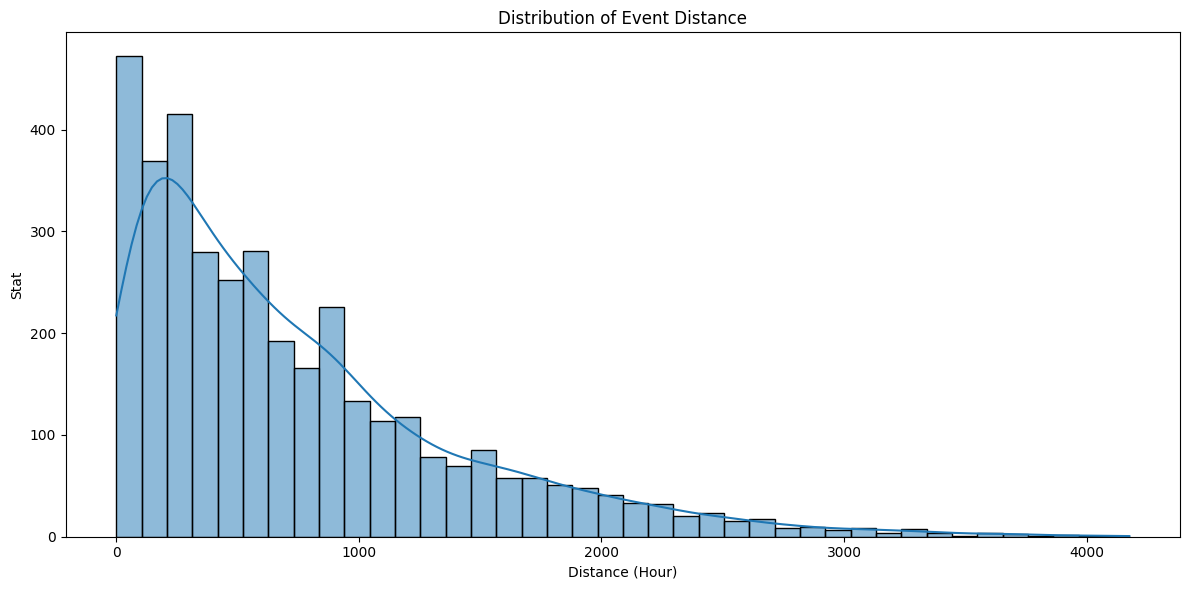

TypeError: 'NoneType' object is not subscriptable

In [97]:

dsa = DescStatsAnalyzer()

DescStatsAnalyzer.plot_event_distance_hist(ef, event_from=['event1', 'event4'], event_to=['event2', 'event3'], plot_period='h')['event'].unique()
# .sort_values(by=['user_id', 'event_datetime'])

In [48]:
data[data['user_id'] == 'user1'].sort_values(by=['user_id', 'event_datetime'])

,user_id,event,event_datetime,city,operation_system,status
31830,user1,event10,2024-11-25 11:42:11.591269,city8,iOS,status1
31616,user1,event2,2024-12-14 11:42:11.591269,city2,Android,status2
18436,user1,event8,2024-12-24 11:42:11.591269,city2,iOS,status2
32891,user1,event2,2024-12-26 11:42:11.591269,city3,Android,status2
15072,user1,event3,2025-01-02 11:42:11.591269,city4,Android,status2
36423,user1,event5,2025-01-21 11:42:11.591269,city9,iOS,status1
26170,user1,event1,2025-01-23 11:42:11.591269,city9,Android,status2
44481,user1,event3,2025-02-08 11:42:11.591269,city8,Android,status2
44638,user1,event2,2025-02-13 11:42:11.591269,city10,Android,status2
40270,user1,event8,2025-03-08 11:42:11.591269,city8,iOS,status1


In [38]:
data[data['event'].isin(['event1', 'event2'])]\
    .pivot_table(index='user_id', columns='event', values='event_datetime', aggfunc='min')\
    .reset_index().dropna()

event,user_id,event1,event2
0,user1,2025-01-23 11:42:11.591269,2024-12-14 11:42:11.591269
2,user100,2024-12-19 11:42:11.591269,2025-02-28 11:42:11.591269
4,user1001,2025-03-16 11:42:11.591269,2024-11-09 11:42:11.591269
7,user1005,2024-10-16 11:42:11.591269,2024-10-17 11:42:11.591269
10,user1008,2024-11-25 11:42:11.591269,2025-03-24 11:42:11.591269
...,...,...,...
4304,user990,2024-11-25 11:42:11.591269,2024-12-17 11:42:11.591269
4305,user991,2024-12-19 11:42:11.591269,2024-11-12 11:42:11.591269
4306,user992,2025-02-08 11:42:11.591269,2024-10-05 11:42:11.591269
4310,user996,2025-01-06 11:42:11.591269,2024-11-23 11:42:11.591269


In [88]:
data['event'].unique()

array(['event6', 'event5', 'event1', 'event2', 'event7', 'event8',
       'event3', 'event4', 'event10', 'event9'], dtype=object)

In [36]:
data[data['user_id']=='user10']

,user_id,event,event_datetime,city,operation_system,status
616,user10,event10,2024-11-18 11:42:11.591269,city5,iOS,status2
846,user10,event6,2024-11-13 11:42:11.591269,city2,Android,status1
1916,user10,event4,2024-10-13 11:42:11.591269,city4,Android,status2
8640,user10,event3,2024-11-03 11:42:11.591269,city10,iOS,status2
14935,user10,event4,2025-03-27 11:42:11.591269,city10,iOS,status2
22030,user10,event2,2024-11-18 11:42:11.591269,city5,Android,status2
32427,user10,event2,2024-12-20 11:42:11.591269,city3,iOS,status1
37864,user10,event10,2024-12-12 11:42:11.591269,city4,Android,status2
37889,user10,event2,2025-03-20 11:42:11.591269,city6,Android,status1
41461,user10,event9,2024-10-24 11:42:11.591269,city6,iOS,status2


In [ ]:
dsa.describe(add_path_stats=True)

value
category             metric                                     
overall              unique_users                             50
                     unique_events                            10
                     unique_sessions                          50
                     frame_start      2024-10-02 14:41:03.899118
                     frame_end        2025-03-29 14:41:03.898131
                     frame_duration     177 days 23:59:59.999013
path_duration        mean                        0 days 00:00:00
                     median                      0 days 00:00:00
                     std                         0 days 00:00:00
                     min                         0 days 00:00:00
                     max                         0 days 00:00:00
path_steps_length    mean                                    1.0
                     median                                  1.0
                     std                                     0.0
                     min                                       1
                     max                                       1
session_duration     mean                        0 days 00:00:00
                     median                      0 days 00:00:00
                     std                         0 days 00:00:00
                     min                         0 days 00:00:00
                     max                         0 days 00:00:00
session_steps_length mean                                    1.0
                     median                                  1.0
                     std                                     0.0
                     min                                       1
                     max                                       1

In [ ]:
data
# data.groupby('user_id')['event_datetime'].transform('min')

,user_id,event,event_datetime,city,operation_system,status
0,user103,event3,2024-11-26 14:41:03.899118,city7,iOS,status2
1,user436,event7,2025-02-17 14:41:03.898131,city1,Android,status2
2,user861,event4,2024-10-24 14:41:03.899118,city4,iOS,status1
3,user271,event9,2025-03-15 14:41:03.898131,city4,iOS,status2
4,user107,event3,2025-02-13 14:41:03.898131,city5,iOS,status1
5,user72,event5,2025-01-24 14:41:03.898131,city7,Android,status2
6,user701,event3,2024-12-31 14:41:03.898131,city7,Android,status1
7,user21,event7,2025-01-18 14:41:03.898131,city4,Android,status1
8,user615,event5,2025-03-21 14:41:03.898131,city7,Android,status1
9,user122,event9,2025-01-01 14:41:03.898131,city3,iOS,status2
